# Dose Response Curve Fitting in Python

## Setting up the stage

While I would naturally fit dose-response curves in R using *drc*, recently I have started using iPython more and more and was wondering : "Can I do curve fitting in Python directly?"

Turns out this is quite easy, although not necessarily well documented. Let's create a toy example and see how things are done using *scipy.optimize* & *pandas*

In [ ]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
import seaborn as sns
%matplotlib inline

Let's use a 4-parameter sigmoidal function as a starting point:

In [ ]:
def ll4(x,b,c,d,e):
    '''This function is basically a copy of the LL.4 function from the R drc package with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50'''
    return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))

def pDose(x):
    '''This is just a helper function, to compute easily log transformed concentrations used in drug discovery'''
    return(-np.log10(1e-6*x))

## Generating data

Lets generate a set of basic curves using a range of parameters

In [ ]:
params = [{'compound':'A', 'b':1, 'c':0, 'd':100, 'e':0.4,'startDose':10, 'nDose':8, 'dilution':3},
          {'compound':'B', 'b':0.7, 'c':0, 'd':86, 'e':1.3,'startDose':30, 'nDose':8, 'dilution':3},
          {'compound':'C', 'b':2, 'c':24, 'd':152, 'e':0.02,'startDose':3, 'nDose':8, 'dilution':3}]
paramsCompound = [item['compound'] for item in params]

replicates are generated by adding random noise to the reference curve:

In [ ]:
drData=[]
for curve in params:
    # generate base curve
    curData = pd.DataFrame(data={'compound':curve['compound'],
                                 'dose':curve['startDose']/np.power(curve['dilution'],range(curve['nDose']))})
    curData['logDose'] = pDose(curData.dose)
    curData['response'] = curData.dose.apply(lambda x: ll4(x,*[curve[i] for i in ['b','c','d','e']]))
    # generate replicates
    repData = []
    for i in range(5):
        rep = curData
        rep.response += 0.25*np.random.normal(len(rep.response))
        repData.append(rep.copy())
    repData = pd.concat(repData)
    drData.append(repData)
# assemble data
drData = pd.concat(drData)
drData.head()

,compound,dose,logDose,response
0,A,10.000000,5.000000,6.213773
1,A,3.333333,5.477121,13.081905
2,A,1.111111,5.954243,28.838208
3,A,0.370370,6.431364,54.290696
4,A,0.123457,6.908485,78.782714


## Fitting the curve

is as simple as

In [ ]:
compoundData = drData.groupby(['compound'])
fitData = []
for name,group in compoundData:
    fitCoefs, covMatrix = opt.curve_fit(ll4, group.dose, group.response)
    resids = group.response-group.dose.apply(lambda x: ll4(x,*fitCoefs))
    curFit = dict(zip(['b','c','d','e'],fitCoefs))
    curFit['compound']=name
    curFit['residuals']=sum(resids**2)
    fitData.append(curFit)
fitCompound = [ item['compound'] for item in fitData]

In [ ]:
fitTable = pd.DataFrame(fitData).set_index('compound')
fitTable

,b,c,d,e,residuals
compound,,,,,
A,1.0,6.362122,106.362122,0.40,329.722191
B,0.7,6.256249,92.256249,1.30,418.282553
C,2.0,29.832769,157.832769,0.02,275.657751


In [ ]:
fitTable = pd.DataFrame(fitData).set_index('compound')
paramTable = pd.DataFrame(params).set_index('compound')[['b','c','d','e']]
paramTable.columns = ['ref_'+i for i in paramTable.columns]
fitTable.join(paramTable)

,b,c,d,e,residuals,ref_b,ref_c,ref_d,ref_e
compound,,,,,,,,,
A,1.0,6.362122,106.362122,0.40,329.722191,1.0,0,100,0.40
B,0.7,6.256249,92.256249,1.30,418.282553,0.7,0,86,1.30
C,2.0,29.832769,157.832769,0.02,275.657751,2.0,24,152,0.02


The model can be plotted as follows:

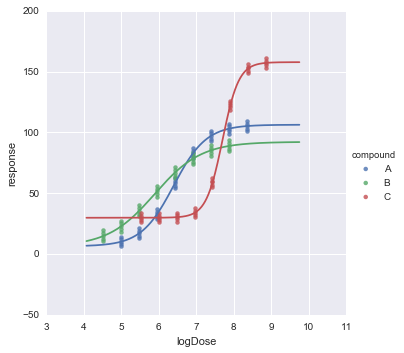

In [ ]:
refDose = np.linspace(min(drData.logDose)*0.9,max(drData.logDose)*1.1,256)
refDose = (10**-refDose)*1e6
sns.lmplot('logDose','response',data=drData,hue='compound',fit_reg=False)
for fit in fitData:
    sns.plt.plot([pDose(i) for i in refDose],[ll4(i,*[fit[i] for i in ['b','c','d','e']]) for i in refDose])